**integrantes**

Sharik Camila Rueda Lucero

Juan Camilo Molina Mussen

Daniel Gonzalez

Nicolas Cardona

### Estrategia implementada para la obtención de nuevos datos

Con el fin de aumentar la diversidad y representatividad del conjunto de datos, se implementó una estrategia colaborativa de intercambio de videos con otros grupos del curso.
Cada grupo compartió sus grabaciones originales, que contenían personas realizando las distintas actividades del sistema (caminar hacia adelante, caminar hacia atrás, girar, sentarse y levantarse), bajo diferentes condiciones de iluminación, perspectiva y velocidad de movimiento.

Este intercambio permitió **incrementar la biodiversidad de los datos** en términos de:

* Diferentes **personas** (variabilidad corporal y de postura).
* **Entornos** de grabación distintos (fondos, iluminación, distancia a la cámara).
* Variaciones en la **velocidad y dirección** del movimiento.
* Diferentes **ángulos de cámara**.

Gracias a esta colaboración, el conjunto de datos final se volvió más robusto y generalizable, lo que favorece el entrenamiento de modelos con mejor capacidad de adaptación a escenarios reales y reduce el riesgo de sobreajuste a un solo tipo de entorno o persona.

Además, todos los videos recibidos se procesaron con el mismo flujo de trabajo de **detección de landmarks usando MediaPipe**, asegurando la **consistencia en el formato de los datos** (mismo número de puntos articulares, estructura de coordenadas y etiquetado uniforme).

## Contexto del Proyecto
Este proyecto tiene como propósito desarrollar un modelo capaz de reconocer acciones humanas a partir de secuencias de video, utilizando la librería MediaPipe para la extracción de poses corporales y características derivadas de las posiciones articulares.

La decisión de utilizar **MediaPipe Pose** se fundamenta en su equilibrio entre precisión y eficiencia computacional, lo que permite procesar videos en tiempo real sin requerir una GPU potente. Además, su integración en Python y compatibilidad con OpenCV facilita la visualización y extracción de datos estructurados (landmarks).

El objetivo final es disponer de un dataset enriquecido que permita analizar, clasificar y eventualmente entrenar modelos de predicción basados en las posturas detectadas.


In [12]:
# Monta tu Drive
from google.colab import drive
drive.mount('/content/drive')

# Instala dependencias
!pip uninstall -y numpy opencv-python opencv-contrib-python opencv-python-headless mediapipe
!pip install numpy==1.26.4 mediapipe==0.10.20 pandas==2.2.2 matplotlib seaborn tqdm opencv-python-headless==4.9.0.80

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
Found existing installation: opencv-python-headless 4.9.0.80
Uninstalling opencv-python-headless-4.9.0.80:
  Successfully uninstalled opencv-python-headless-4.9.0.80
Found existing installation: mediapipe 0.10.20
Uninstalling mediapipe-0.10.20:
  Successfully uninstalled mediapipe-0.10.20
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached mediapipe-0.10.20-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata 

In [1]:
import os
import re
import cv2
import time
import math
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [2]:
# Ruta base del proyecto
BASE_PATH = "/content/drive/MyDrive/Entregas_Proyecto"

# Carpeta con los videos originales
VIDEOS_PATH = os.path.join(BASE_PATH, "videos")

# Carpeta de resultados
RESULTS_PATH = os.path.join(BASE_PATH, "resultados")

# Subcarpetas de resultados
POSE_DIR    = os.path.join(RESULTS_PATH, "videos_pose")   # videos procesados con pose
METRICS_DIR = os.path.join(RESULTS_PATH, "metrics")       # CSVs con métricas

# Crea las carpetas necesarias
os.makedirs(POSE_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print("Directorios configurados:")
print("BASE_PATH   :", BASE_PATH)
print("VIDEOS_PATH :", VIDEOS_PATH)
print("POSE_DIR    :", POSE_DIR)
print("METRICS_DIR :", METRICS_DIR)


Directorios configurados:
BASE_PATH   : /content/drive/MyDrive/Entregas_Proyecto
VIDEOS_PATH : /content/drive/MyDrive/Entregas_Proyecto/videos
POSE_DIR    : /content/drive/MyDrive/Entregas_Proyecto/resultados/videos_pose
METRICS_DIR : /content/drive/MyDrive/Entregas_Proyecto/resultados/metrics


In [ ]:


# Configuración de MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

POSE = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,          # 0,1,2 -> 1 equilibrio latencia/precisión
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Índices de landmarks (33 puntos)
LHIP  = mp_pose.PoseLandmark.LEFT_HIP.value
RHIP  = mp_pose.PoseLandmark.RIGHT_HIP.value
LSHO  = mp_pose.PoseLandmark.LEFT_SHOULDER.value
RSHO  = mp_pose.PoseLandmark.RIGHT_SHOULDER.value
LKNE  = mp_pose.PoseLandmark.LEFT_KNEE.value
RKNE  = mp_pose.PoseLandmark.RIGHT_KNEE.value
LANK  = mp_pose.PoseLandmark.LEFT_ANKLE.value
RANK  = mp_pose.PoseLandmark.RIGHT_ANKLE.value


### Decisiones sobre la configuración técnica

La configuración técnica incluye la instalación de versiones específicas de librerías para garantizar compatibilidad, especialmente entre `numpy`, `opencv` y `mediapipe`. Se seleccionó:

- `mediapipe==0.10.20` por su estabilidad en detección de poses.
- `numpy==1.26.4` para mantener compatibilidad con las versiones recientes de TensorFlow y OpenCV.

En cuanto a `model_complexity=1`, se eligió este valor por ofrecer un **balance entre precisión y velocidad**, evitando la latencia que introduce el nivel 2 sin sacrificar demasiada exactitud en la estimación de articulaciones.


In [ ]:
def angle_between(p_a, p_b, p_c):
    """
    Ángulo ABC (en grados) con vértice en B.
    p_* son tuplas (x, y) en píxeles.
    """
    a, b, c = map(lambda p: np.array(p, dtype=float), (p_a, p_b, p_c))
    v1, v2 = a - b, c - b
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2))
    if denom == 0:
        return np.nan
    cosang = np.clip(np.dot(v1, v2) / denom, -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

def hip_center(landmarks_px):
    """Centro de cadera (promedio de cadera izq/der) en píxeles."""
    lh, rh = landmarks_px[LHIP], landmarks_px[RHIP]
    return ((lh[0] + rh[0]) / 2.0, (lh[1] + rh[1]) / 2.0)

def shoulder_inclination(landmarks_px):
    """
    Inclinación promedio de hombros (diferencia vertical, en píxeles).
    Positivo si el hombro derecho está más abajo que el izquierdo.
    """
    lsh, rsh = landmarks_px[LSHO], landmarks_px[RSHO]
    return rsh[1] - lsh[1]

def average_knee_angle(landmarks_px):
    """
    Ángulo promedio de rodillas (en grados) combinando izquierda y derecha.
    """
    lk = angle_between(landmarks_px[LHIP], landmarks_px[LKNE], landmarks_px[LANK])
    rk = angle_between(landmarks_px[RHIP], landmarks_px[RKNE], landmarks_px[RANK])
    return np.nanmean([lk, rk])

def avg_frame_brightness(frame_bgr):
    """Brillo promedio (0-255) del frame en escala de grises."""
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    return float(np.mean(gray))

def interframe_displacement(prev_points, curr_points, use_subset=True):
    """
    Movimiento promedio: distancia euclídea entre frames consecutivos
    (promedio sobre un subconjunto estable de landmarks).
    """
    if prev_points is None or curr_points is None:
        return np.nan
    idxs = [LSHO, RSHO, LHIP, RHIP, LKNE, RKNE, LANK, RANK] if use_subset else range(len(curr_points))
    dists = []
    for i in idxs:
        p, q = prev_points[i], curr_points[i]
        if p is None or q is None:
            continue
        dists.append(math.dist(p, q))
    return float(np.mean(dists)) if dists else np.nan


In [ ]:
# === Mapeo de acción desde el nombre del archivo (ajustado a tus videos) ===
# Canonicalizamos a estas etiquetas:
#   caminar_hacia_adelante, caminar_atras,
#   pararse, sentarse,
#   girar_derecha

ACTION_PATTERNS = {
    # Caminar frontal
    "caminar_hacia_adelante":  r"(?:^|[_\- ])caminar(?:[_\- ])hacia(?:[_\- ])adelante\d*(?:$|\.)",

    # Caminar atrás
    "caminar_atras":           r"(?:^|[_\- ])caminar(?:[_\- ])atras\d*(?:$|\.)",

    # Acciones estáticas
    "pararse":                 r"(?:^|[_\- ])pararse\d*(?:$|\.)",
    "sentarse":                r"(?:^|[_\- ])sentarse\d*(?:$|\.)",

    # Giros / vueltas
    "girar_derecha":          r"(?:^|[_\- ])(?:vuelta|girar)(?:[_\- ])derecha\d*(?:$|\.)",
}


def infer_action_from_filename(fname: str) -> str:
    """
    Devuelve la etiqueta canónica de acción con base en el nombre del archivo.
    Es robusto a espacios/guiones/guiones bajos. Si no matchea, devuelve 'desconocida'.
    """
    base = os.path.basename(fname).lower()
    base = base.replace(" ", "_")  # normalizamos espacios a _
    for action, pattern in ACTION_PATTERNS.items():
        if re.search(pattern, base):
            return action
    return "desconocida"


In [ ]:
def landmarks_to_pixel_list(landmarks, width, height, min_visibility=0.5):
    """
    Convierte landmarks normalizados a (x_px, y_px) o None si visibilidad baja.
    """
    pts = []
    for lm in landmarks:
        x_px = int(lm.x * width)
        y_px = int(lm.y * height)
        if lm.visibility is not None and lm.visibility < min_visibility:
            pts.append(None)
        else:
            pts.append((x_px, y_px))
    return pts


In [ ]:
def process_video(in_path, out_path, collect_frames=False):
    """
    - Lee el video de entrada.
    - Ejecuta MediaPipe Pose.
    - Dibuja el esqueleto y overlay de métricas.
    - Guarda un nuevo video en out_path.
    - Devuelve: resumen por video y (opcional) DataFrame por frame.
    """
    cap = cv2.VideoCapture(in_path)
    if not cap.isOpened():
        print(f"[WARN] No se pudo abrir: {in_path}")
        return None, None

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    nfr = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    hip_speeds, incl_shoulders, knee_angles, movements, brightness = [], [], [], [], []
    frames_records = [] if collect_frames else None

    prev_hip_center = None
    prev_pts = None
    frame_idx = 0

    pbar = tqdm(total=nfr if nfr>0 else None, desc=os.path.basename(in_path), leave=False)
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = POSE.process(frame_rgb)

        curr_pts, hc = None, None
        sh_inc, knee = np.nan, np.nan

        if res.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                res.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2),
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=2)
            )
            curr_pts = landmarks_to_pixel_list(res.pose_landmarks.landmark, w, h, min_visibility=0.5)
            try:    hc    = hip_center(curr_pts)
            except: hc    = None
            try:    sh_inc = shoulder_inclination(curr_pts)
            except: sh_inc = np.nan
            try:    knee   = average_knee_angle(curr_pts)
            except: knee   = np.nan

        hip_speed = np.nan
        if hc is not None and prev_hip_center is not None:
            hip_speed = math.dist(hc, prev_hip_center)

        move_avg  = interframe_displacement(prev_pts, curr_pts, use_subset=True)
        bri       = avg_frame_brightness(frame)

        hip_speeds.append(hip_speed)
        incl_shoulders.append(sh_inc)
        knee_angles.append(knee)
        movements.append(move_avg)
        brightness.append(bri)

        # Overlay simple
        overlay = f"hip_v(px/f): {hip_speed:5.1f} | sh_tilt(px): {sh_inc:6.1f} | knee(deg): {knee:6.1f}"
        cv2.rectangle(frame, (10,10), (10+630, 10+30), (0,0,0), thickness=-1)
        cv2.putText(frame, overlay, (18,32), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2, cv2.LINE_AA)

        out.write(frame)

        if collect_frames:
            frames_records.append({
                "video": os.path.basename(in_path),
                "frame": frame_idx,
                "hip_speed_px_per_frame": hip_speed,
                "shoulder_tilt_px": sh_inc,
                "knee_angle_deg": knee,
                "movement_avg_px": move_avg,
                "brightness": bri
            })

        prev_hip_center = hc
        prev_pts = curr_pts
        frame_idx += 1
        pbar.update(1)
    pbar.close()

    cap.release()
    out.release()

    duration_s = frame_idx / fps if fps > 0 else np.nan
    summary = {
        "video": os.path.basename(in_path),
        "frames": frame_idx,
        "fps": fps,
        "duration_s": duration_s,
        "brightness_avg": np.nanmean(brightness),
        "hip_speed_avg_px_per_frame": np.nanmean(hip_speeds),
        "shoulder_tilt_avg_px": np.nanmean(incl_shoulders),
        "knee_angle_avg_deg": np.nanmean(knee_angles),
        "movement_avg_px": np.nanmean(movements),
    }

    df_frames = pd.DataFrame(frames_records) if collect_frames else None
    return summary, df_frames


### Funciones auxiliares implementadas
Se implementaron funciones personalizadas para mejorar la trazabilidad y flexibilidad del pipeline de procesamiento:

- `angle_between()`: calcula ángulos entre tres puntos articulares, útil para caracterizar movimientos (por ejemplo, flexión o extensión).
- `landmarks_to_pixel_list()`: convierte coordenadas normalizadas de MediaPipe a valores en píxeles, manejando visibilidad mínima para evitar ruido.
- `process_video()`: combina el procesamiento frame a frame, la extracción de poses y la generación de resúmenes por video.

Estas funciones permiten obtener un **resumen estructurado de cada acción**, que luego se puede analizar estadísticamente o usar como entrada para modelos.


In [ ]:
# Listar videos en VIDEOS_PATH (mp4, mov, avi, mkv)
videos = [os.path.join(VIDEOS_PATH, f)
          for f in os.listdir(VIDEOS_PATH)
          if f.lower().endswith((".mp4", ".mov", ".avi", ".mkv"))]

if not videos:
    print("No se encontraron videos en:", VIDEOS_PATH)

summaries = []
frames_all = []

for v in videos:
    action = infer_action_from_filename(v)
    out_name = f"{os.path.splitext(os.path.basename(v))[0]}__pose.mp4"
    out_path = os.path.join(POSE_DIR, out_name)

    summary, df_frames = process_video(v, out_path, collect_frames=False)  # pon True si quieres CSV por frame

    if summary:
        summary["action"] = action
        summaries.append(summary)
    if df_frames is not None and not df_frames.empty:
        df_frames["action"] = action
        frames_all.append(df_frames)

# Guardar CSVs en Drive
df_summary = pd.DataFrame(summaries).sort_values(by="video")
summary_csv = os.path.join(METRICS_DIR, "metrics_por_video.csv")
df_summary.to_csv(summary_csv, index=False)

if frames_all:
    df_frames_all = pd.concat(frames_all, ignore_index=True)
    frames_csv = os.path.join(METRICS_DIR, "frames_detalle.csv")
    df_frames_all.to_csv(frames_csv, index=False)

print("CSV de métricas por video guardado en:", summary_csv)
if frames_all:
    print("CSV de detalle por frame guardado en:", frames_csv)

df_summary


Streaming output truncated to the last 5000 lines.
caminar_atras3.mp4:  99%|█████████▊| 72/73 [00:05<00:00, 13.68it/s]
                                                                   
caminar_atras8.mp4: 100%|██████████| 90/90 [00:09<00:00, 13.31it/s]
                                                                   
caminar_atras13.mp4: 100%|██████████| 102/102 [00:09<00:00,  9.15it/s]
                                                                      
caminar_atras17.mp4:  99%|█████████▊| 72/73 [00:06<00:00, 13.14it/s]
                                                                    
caminar_atras4.mp4: 100%|██████████| 67/67 [00:06<00:00,  9.16it/s]
                                                                   
caminar_atras19.mp4: 100%|██████████| 81/81 [00:06<00:00, 13.24it/s]
                                                                    
caminar_atras6.mp4: 100%|██████████| 66/66 [00:06<00:00,  8.90it/s]
                                                       

CSV de métricas por video guardado en: /content/drive/MyDrive/Entregas_Proyecto/resultados/metrics/metrics_por_video.csv


,video,frames,fps,duration_s,brightness_avg,hip_speed_avg_px_per_frame,shoulder_tilt_avg_px,knee_angle_avg_deg,movement_avg_px,action
65,caminar_atras1.mp4,175,30.023619,5.828744,148.237705,1.223767,2.205714,173.891620,1.463778,caminar_atras
30,caminar_atras10.mp4,73,30.000000,2.433333,143.953716,5.655313,-8.616438,176.038877,6.955742,caminar_atras
29,caminar_atras11.mp4,63,30.000000,2.100000,141.253348,4.285994,4.968254,176.899638,9.157905,caminar_atras
16,caminar_atras12.mp4,91,30.000000,3.033333,147.279697,4.030225,-0.329670,177.539749,5.761545,caminar_atras
23,caminar_atras13.mp4,102,30.000000,3.400000,142.248199,3.586545,11.108911,175.139436,4.644624,caminar_atras
...,...,...,...,...,...,...,...,...,...,...
54,sentarse5.mp4,123,30.000000,4.100000,149.411458,2.196903,-1.837398,157.269049,1.940463,sentarse
49,sentarse6.mp4,143,30.000000,4.766667,147.580930,2.706944,-5.062937,147.695462,3.113469,sentarse
62,sentarse7.mp4,108,30.000000,3.600000,148.618064,2.287872,1.129630,163.949920,2.146886,sentarse
61,sentarse8.mp4,89,30.000000,2.966667,147.964782,2.949340,1.550562,175.354510,2.112868,sentarse


## **1. Análisis Exploratorio de los Datos - Limpieza - Preparación**

### Justificación del análisis exploratorio

El análisis exploratorio busca comprender la estructura del conjunto de datos generado a partir del procesamiento de los videos.  
Se revisaron los siguientes aspectos:

- **Dimensionalidad**: número de filas (frames o muestras) y columnas (características o ángulos articulares).  
- **Tipos de datos**: para identificar si las variables numéricas o categóricas están correctamente definidas.  
- **Valores nulos o repetidos**: para asegurar que la información es consistente y no contiene redundancias que afecten el modelado.

Esta etapa permite **detectar errores en la captura de landmarks** o inconsistencias en los datos derivados de MediaPipe.


### 1.1 Conocimiento Básico del Dataset

Determinar:
+ Tamaño del Dataset (filas y columnas)
+ Columnas y tipos de datos
+ Vista Preliminar
+ Datos Nulos y Datos Repetidos

In [ ]:
pd.set_option('display.max_rows', None)

In [3]:
df_summary = pd.read_csv(os.path.join(METRICS_DIR, "metrics_por_video.csv"))

df_summary.shape

(81, 10)

In [ ]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 65 to 56
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   video                       81 non-null     object 
 1   frames                      81 non-null     int64  
 2   fps                         81 non-null     float64
 3   duration_s                  81 non-null     float64
 4   brightness_avg              81 non-null     float64
 5   hip_speed_avg_px_per_frame  81 non-null     float64
 6   shoulder_tilt_avg_px        81 non-null     float64
 7   knee_angle_avg_deg          81 non-null     float64
 8   movement_avg_px             81 non-null     float64
 9   action                      81 non-null     object 
dtypes: float64(7), int64(1), object(2)
memory usage: 7.0+ KB


In [ ]:
df_summary.dtypes

,0
video,object
frames,int64
fps,float64
duration_s,float64
brightness_avg,float64
hip_speed_avg_px_per_frame,float64
shoulder_tilt_avg_px,float64
knee_angle_avg_deg,float64
movement_avg_px,float64
action,object


In [ ]:
df_summary.head()

,video,frames,fps,duration_s,brightness_avg,hip_speed_avg_px_per_frame,shoulder_tilt_avg_px,knee_angle_avg_deg,movement_avg_px,action
65,caminar_atras1.mp4,175,30.023619,5.828744,148.237705,1.223767,2.205714,173.891620,1.463778,caminar_atras
30,caminar_atras10.mp4,73,30.000000,2.433333,143.953716,5.655313,-8.616438,176.038877,6.955742,caminar_atras
29,caminar_atras11.mp4,63,30.000000,2.100000,141.253348,4.285994,4.968254,176.899638,9.157905,caminar_atras
16,caminar_atras12.mp4,91,30.000000,3.033333,147.279697,4.030225,-0.329670,177.539749,5.761545,caminar_atras
23,caminar_atras13.mp4,102,30.000000,3.400000,142.248199,3.586545,11.108911,175.139436,4.644624,caminar_atras


In [ ]:
df_summary.tail()

,video,frames,fps,duration_s,brightness_avg,hip_speed_avg_px_per_frame,shoulder_tilt_avg_px,knee_angle_avg_deg,movement_avg_px,action
54,sentarse5.mp4,123,30.0,4.100000,149.411458,2.196903,-1.837398,157.269049,1.940463,sentarse
49,sentarse6.mp4,143,30.0,4.766667,147.580930,2.706944,-5.062937,147.695462,3.113469,sentarse
62,sentarse7.mp4,108,30.0,3.600000,148.618064,2.287872,1.129630,163.949920,2.146886,sentarse
61,sentarse8.mp4,89,30.0,2.966667,147.964782,2.949340,1.550562,175.354510,2.112868,sentarse
56,sentarse9.mp4,125,30.0,4.166667,148.024111,2.155550,-7.856000,175.789540,2.178047,sentarse


In [ ]:
df_summary.isna().sum()

,0
video,0
frames,0
fps,0
duration_s,0
brightness_avg,0
hip_speed_avg_px_per_frame,0
shoulder_tilt_avg_px,0
knee_angle_avg_deg,0
movement_avg_px,0
action,0


In [ ]:
df_summary.duplicated().sum()

0

### 1.2 Análisis Univariado

Incluye:
+ Medidas de tendencia central: media, mediana, moda.
+ Medidas de dispersión: rango, variance, valor máximo y mínimo, cuartiles (incluyendo rango intercuartil) y desviación estándar.
+ Para variables numéricas discretas y categóricas: cantidad de valores únicos, valor con mayor frecuencia, etc.

También se pueden se pueden usar gráficos como:
+ Histogramas.
+ Para variables numéricas discretas y categóricas: gráficos de barras, gráficos circulares.

In [ ]:
df_summary.describe()

,frames,fps,duration_s,brightness_avg,hip_speed_avg_px_per_frame,shoulder_tilt_avg_px,knee_angle_avg_deg,movement_avg_px
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,126.098765,30.077748,4.198908,139.784529,3.206538,3.815250,163.193518,4.286296
std,76.022136,0.220855,2.537759,13.538631,1.384574,11.681838,21.102035,2.791433
min,27.000000,30.000000,0.867857,81.022396,0.877259,-16.064103,93.648386,0.639884
25%,78.000000,30.000000,2.600000,138.593227,2.287872,-3.914894,157.269049,2.178047
50%,97.000000,30.000000,3.233333,142.785212,3.043591,1.129630,174.054908,3.825070
75%,144.000000,30.000000,4.800000,147.790880,4.030225,8.500000,175.642828,5.761545
max,330.000000,31.111111,11.000000,159.205171,6.501684,44.349206,177.877134,18.659505


In [ ]:
df_summary.describe(include ='all')

,video,frames,fps,duration_s,brightness_avg,hip_speed_avg_px_per_frame,shoulder_tilt_avg_px,knee_angle_avg_deg,movement_avg_px,action
count,81,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81
unique,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,caminar_atras1.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caminar_atras
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
mean,NaN,126.098765,30.077748,4.198908,139.784529,3.206538,3.815250,163.193518,4.286296,NaN
std,NaN,76.022136,0.220855,2.537759,13.538631,1.384574,11.681838,21.102035,2.791433,NaN
min,NaN,27.000000,30.000000,0.867857,81.022396,0.877259,-16.064103,93.648386,0.639884,NaN
25%,NaN,78.000000,30.000000,2.600000,138.593227,2.287872,-3.914894,157.269049,2.178047,NaN
50%,NaN,97.000000,30.000000,3.233333,142.785212,3.043591,1.129630,174.054908,3.825070,NaN
75%,NaN,144.000000,30.000000,4.800000,147.790880,4.030225,8.500000,175.642828,5.761545,NaN


In [ ]:
df_summary.describe(include ='object')

,video,action
count,81,81
unique,81,5
top,caminar_atras1.mp4,caminar_atras
freq,1,19


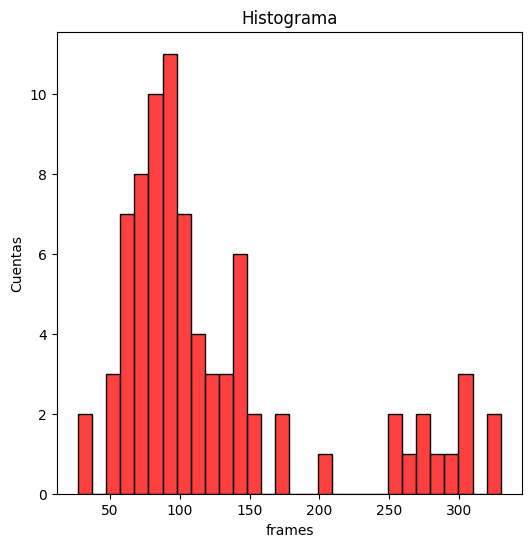

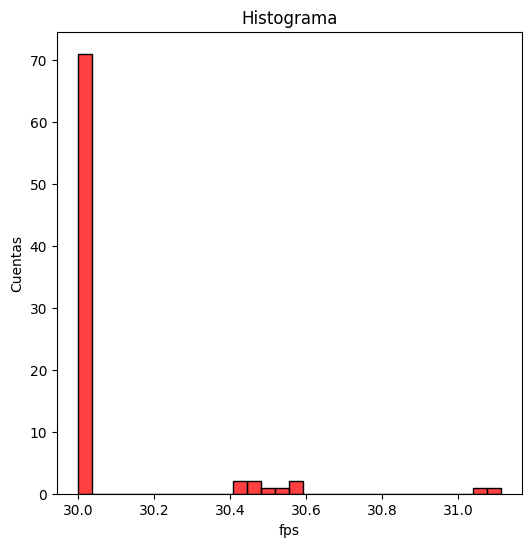

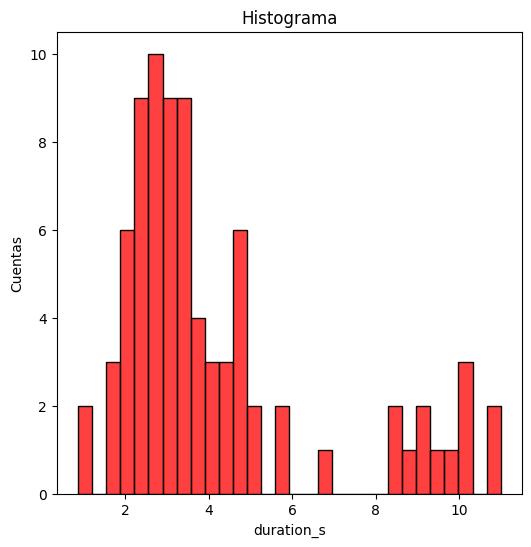

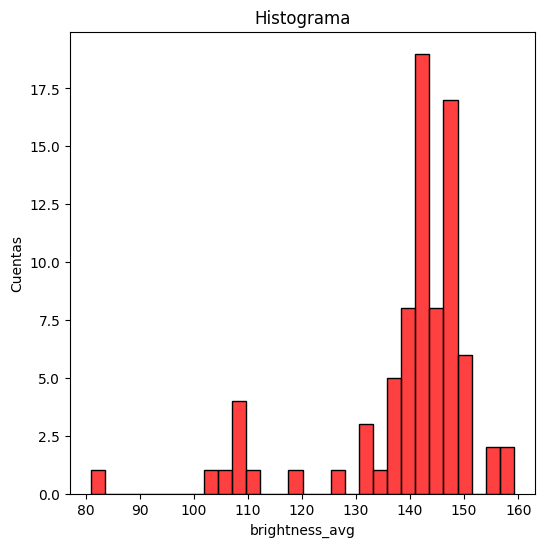

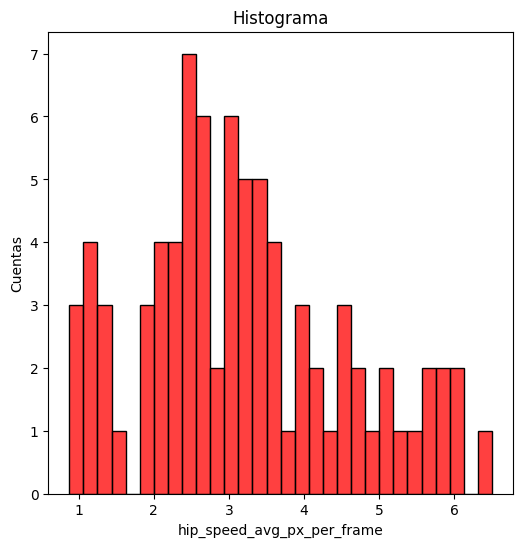

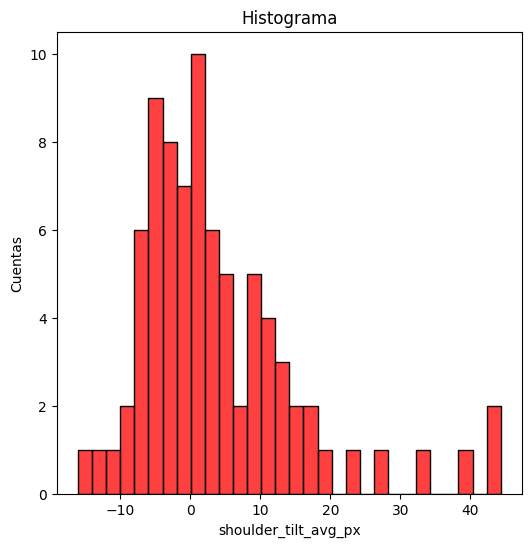

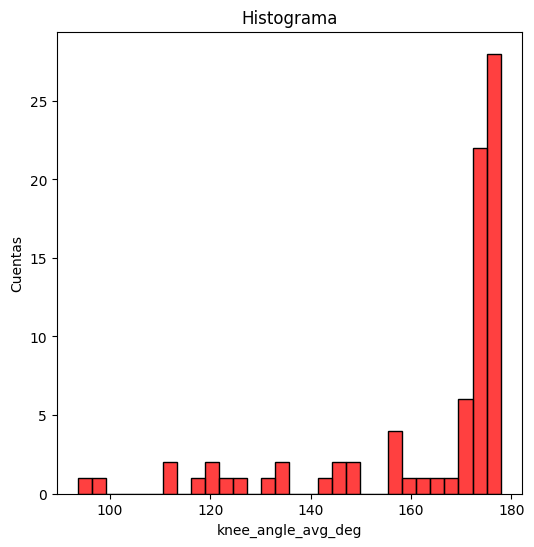

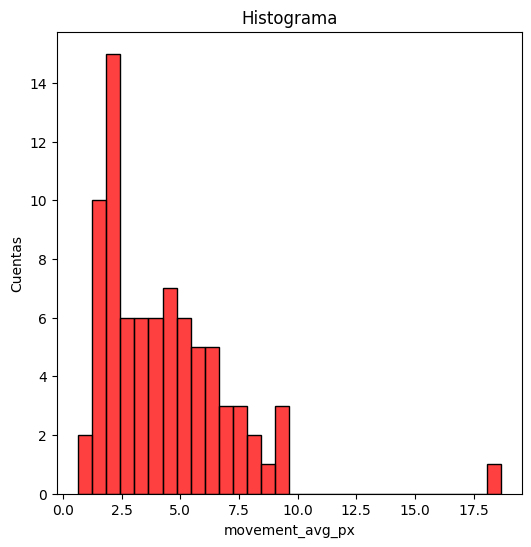

In [ ]:
# Ahora vamos a mostrar el histograma de todos los atributos

num_bins = 30
for column in df_summary.columns:
    if df_summary[column].dtype != 'object':
        plt.figure(figsize=(6,6))
        sns.histplot(data     = df_summary,
             x        =column,
             bins     = num_bins,
             color    = 'red',
             fill     = True,
             stat     = 'count')    #'count' muestra el número de observaciones.
                                    #'frequency' muestra el número de observaciones dividida por el ancho del bin.
                                    #'density' normaliza las cuentas tal que el área del histograma es 1.
                                    #'probability' normaliza las cuentas tal que la suma de la altura de las barras es 1.

        plt.xlabel(column) #Texto en el eje x.
        plt.ylabel('Cuentas')              #Texto en el eje y.
        plt.title('Histograma')             #Título del gráfico.

### 1.3 Análisis Bivariado

Es una técnica estadística que se aplica a un par de variables (atributos o características) para determinar la relación
empírica entre ellas.

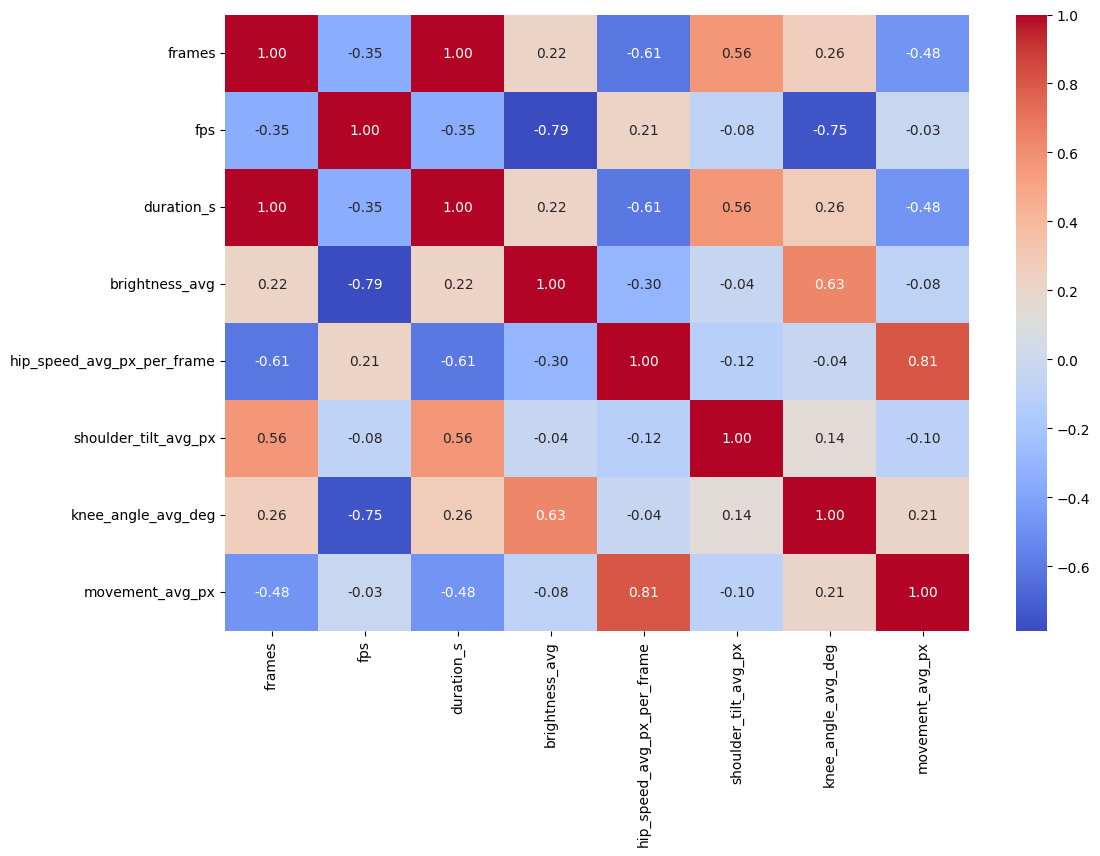


 Correlaciones más relevantes (>|0.7|):


,,0
frames,duration_s,0.999992
hip_speed_avg_px_per_frame,movement_avg_px,0.805787
knee_angle_avg_deg,fps,-0.751481
brightness_avg,fps,-0.787062


In [ ]:
# Calcular matriz de correlación
corr_matrix = df_summary.select_dtypes(include=["float64", "int64"]).corr()

# Mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

# Mostrar las correlaciones más altas (excepto con sí mismas)
corr_pairs = (
    corr_matrix.unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)

print("\n Correlaciones más relevantes (>|0.7|):")
display(corr_pairs[(corr_pairs < 1) & (abs(corr_pairs) > 0.7)])

### Limpieza

Aquí se abordan los problemas identificados en el análisis exploratorio.

### 1.4 Detección de problemas con el conjunto de datos: valores faltantes, valores erróneos, etc.

In [ ]:
df_summary.isna().sum()

,0
video,0
frames,0
fps,0
duration_s,0
brightness_avg,0
hip_speed_avg_px_per_frame,0
shoulder_tilt_avg_px,0
knee_angle_avg_deg,0
movement_avg_px,0
action,0


In [ ]:
df_summary.duplicated().sum()

0

In [ ]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 65 to 56
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   video                       81 non-null     object 
 1   frames                      81 non-null     int64  
 2   fps                         81 non-null     float64
 3   duration_s                  81 non-null     float64
 4   brightness_avg              81 non-null     float64
 5   hip_speed_avg_px_per_frame  81 non-null     float64
 6   shoulder_tilt_avg_px        81 non-null     float64
 7   knee_angle_avg_deg          81 non-null     float64
 8   movement_avg_px             81 non-null     float64
 9   action                      81 non-null     object 
dtypes: float64(7), int64(1), object(2)
memory usage: 7.0+ KB


### 1.5 Detección de valores atípicos (Outliers)

In [ ]:
def outliers(df, atributo):
    ax = sns.boxplot(x=df[atributo])
    plt.show()

    arr1 = df[atributo].values

    # Encontrar el 1st quartil
    q1 = np.quantile(arr1, 0.25)

    # Encontrar el 3rd quartil
    q3 = np.quantile(arr1, 0.75)

    # Encontrar el 2nd quartil
    med = np.median(arr1)

    # Encontrar el rango inter quartil (iqr)
    iqr = q3-q1

    # Encontrar los bigotes superior e inferior
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)

    outliers_l = arr1[(arr1 <= lower_bound)]
    outliers_u = arr1[(arr1 >= upper_bound)]
    print('The following are the lower outliers in {} : {}'.format(atributo,outliers_l))
    print('The following are the upper outliers in {} : {}'.format(atributo,outliers_u))

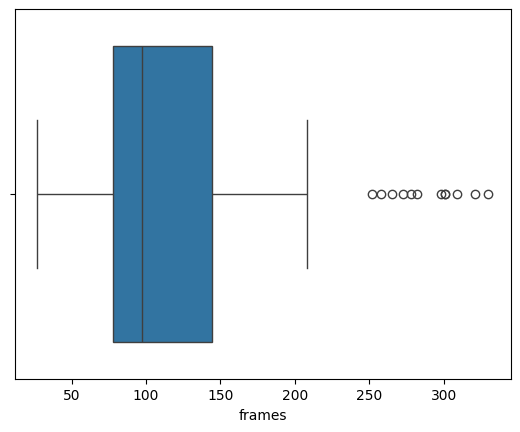

The following are the lower outliers in frames : []
The following are the upper outliers in frames : [278 265 273 258 252 301 282 321 309 330 301 298]


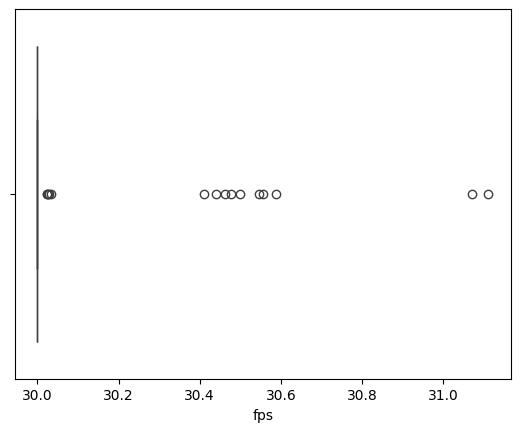

The following are the lower outliers in fps : [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
The following are the upper outliers in fps : [30.02361858 30.         30.         30.         30.         30.
 30.         30.         30.         30.         30.         30.
 30.         30.         30.         30.         30.         30.
 30.         30.03359527 30.         30.         30.         30.
 30.         30.         30.         30.         30.         30.
 30.         30.         30.         30.         30.         30.
 30.         30.         30.02538093 30.         30.         30.
 30.         30.         30.         30.         30.         30.
 30.         30.         30.         30.02873498 30.5        30.54545455
 31.11111111 30.4109589  31.07142857 30.555555

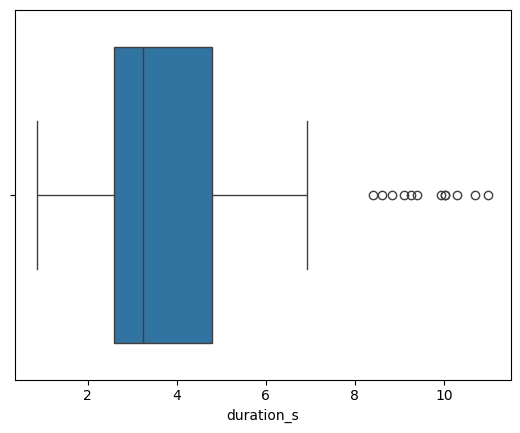

The following are the lower outliers in duration_s : []
The following are the upper outliers in duration_s : [ 9.26666667  8.83333333  9.1         8.6         8.4        10.03333333
  9.4        10.7        10.3        11.         10.03333333  9.93333333]


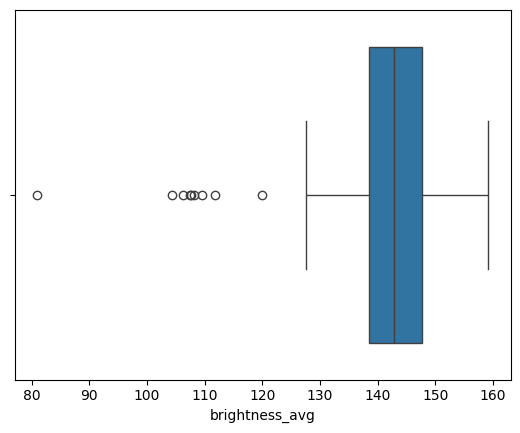

The following are the lower outliers in brightness_avg : [107.60635308 111.84700017 120.00439035 104.35790589 109.60155472
 107.55518532  81.02239581 108.14706709 106.30660353]
The following are the upper outliers in brightness_avg : []


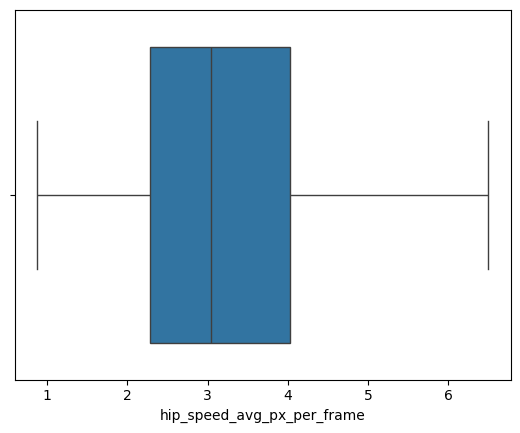

The following are the lower outliers in hip_speed_avg_px_per_frame : []
The following are the upper outliers in hip_speed_avg_px_per_frame : []


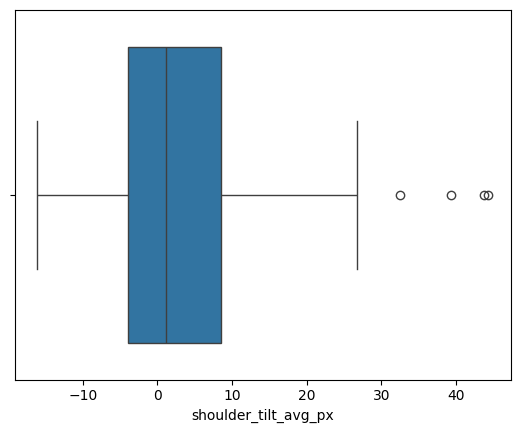

The following are the lower outliers in shoulder_tilt_avg_px : []
The following are the upper outliers in shoulder_tilt_avg_px : [39.32830189 32.57142857 44.34920635 43.77740864]


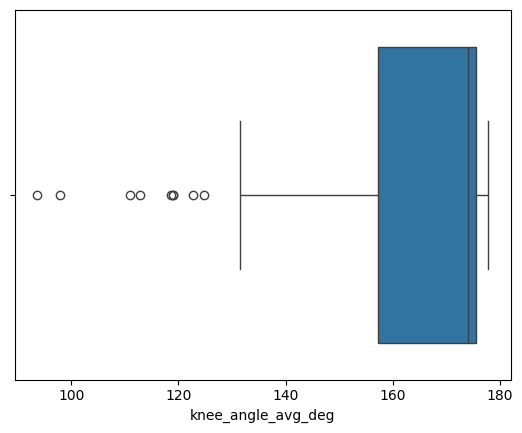

The following are the lower outliers in knee_angle_avg_deg : [119.06002488 110.94555701 119.03649055  93.64838642 118.51241865
  97.91250895 122.7054436  124.69372662 112.73498646]
The following are the upper outliers in knee_angle_avg_deg : []


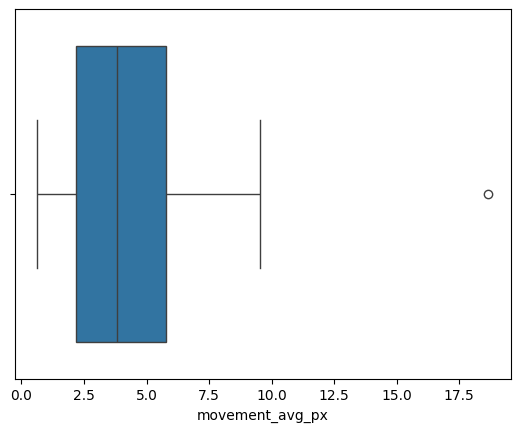

The following are the lower outliers in movement_avg_px : []
The following are the upper outliers in movement_avg_px : [18.65950455]


In [ ]:
for column in df_summary.columns:
    # Check if the column is numeric and not datetime, and if it contains any non-null values
    if df_summary[column].dtype != 'object':
        outliers(df_summary, column)

### 1.6 Solucion a problemas encontrados

In [4]:
df_clean = df_summary.copy()

In [5]:
df_clean.isna().sum()

,0
video,0
frames,0
fps,0
duration_s,0
brightness_avg,0
hip_speed_avg_px_per_frame,0
shoulder_tilt_avg_px,0
knee_angle_avg_deg,0
movement_avg_px,0
action,0


In [6]:
df_clean.duplicated().sum()

0

In [7]:
df_clean = df_clean.drop(columns=["video", "fps"])

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   frames                      81 non-null     int64  
 1   duration_s                  81 non-null     float64
 2   brightness_avg              81 non-null     float64
 3   hip_speed_avg_px_per_frame  81 non-null     float64
 4   shoulder_tilt_avg_px        81 non-null     float64
 5   knee_angle_avg_deg          81 non-null     float64
 6   movement_avg_px             81 non-null     float64
 7   action                      81 non-null     object 
dtypes: float64(6), int64(1), object(1)
memory usage: 5.2+ KB


In [8]:
df_norm = df_clean.copy()

cols_numericas = df_norm.select_dtypes(include=["float64", "int64"]).columns
cols_numericas = [c for c in cols_numericas if c != "action"]

scaler = StandardScaler()
df_norm[cols_numericas] = scaler.fit_transform(df_norm[cols_numericas])

norm_path = os.path.join(RESULTS_PATH, "dataset_normalizado.csv")
df_norm.to_csv(norm_path, index=False)
print(f"Dataset normalizado guardado en: {norm_path}")


Dataset normalizado guardado en: /content/drive/MyDrive/Entregas_Proyecto/resultados/dataset_normalizado.csv


In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_norm["action"])

label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Etiquetas codificadas:", label_map)

Etiquetas codificadas: {'caminar_atras': 0, 'caminar_hacia_adelante': 1, 'girar_derecha': 2, 'pararse': 3, 'sentarse': 4}


In [10]:
X = df_norm.drop(columns=["action"])
y = y_encoded

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
modelos = {
    "RandomForest": {
        "modelo": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "max_depth": [5, 10, 20, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "SVM": {
        "modelo": SVC(probability=True, random_state=42),
        "param_grid": {
            "C": [0.1, 1, 10],
            "gamma": ["scale", "auto"],
            "kernel": ["rbf", "poly"]
        }
    },
    "XGBoost": {
        "modelo": XGBClassifier(random_state=42, objective="multi:softprob", eval_metric='mlogloss'),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0]
        }
    }
}

resultados = {}


=== Entrenando RandomForest ===
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores parámetros para RandomForest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

Reporte de clasificación:
                        precision    recall  f1-score   support

         caminar_atras       1.00      0.25      0.40         4
caminar_hacia_adelante       0.57      1.00      0.73         4
         girar_derecha       1.00      1.00      1.00         3
               pararse       1.00      0.50      0.67         2
              sentarse       0.80      1.00      0.89         4

              accuracy                           0.76        17
             macro avg       0.87      0.75      0.74        17
          weighted avg       0.85      0.76      0.73        17



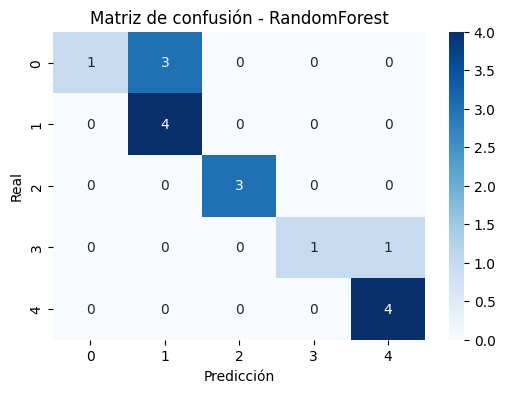


=== Entrenando SVM ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Mejores parámetros para SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Reporte de clasificación:
                        precision    recall  f1-score   support

         caminar_atras       1.00      0.75      0.86         4
caminar_hacia_adelante       0.75      0.75      0.75         4
         girar_derecha       0.75      1.00      0.86         3
               pararse       1.00      0.50      0.67         2
              sentarse       0.80      1.00      0.89         4

              accuracy                           0.82        17
             macro avg       0.86      0.80      0.80        17
          weighted avg       0.85      0.82      0.82        17



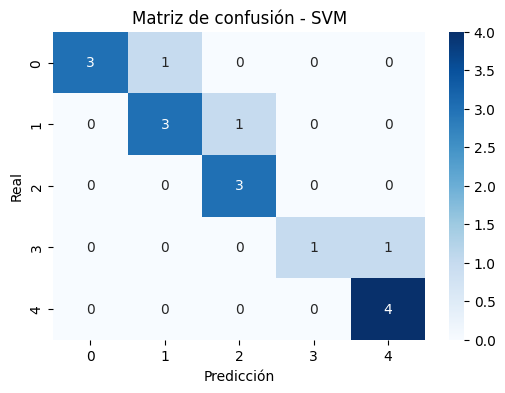


=== Entrenando XGBoost ===
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores parámetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Reporte de clasificación:
                        precision    recall  f1-score   support

         caminar_atras       0.67      0.50      0.57         4
caminar_hacia_adelante       0.50      0.50      0.50         4
         girar_derecha       0.60      1.00      0.75         3
               pararse       0.00      0.00      0.00         2
              sentarse       0.60      0.75      0.67         4

              accuracy                           0.59        17
             macro avg       0.47      0.55      0.50        17
          weighted avg       0.52      0.59      0.54        17



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


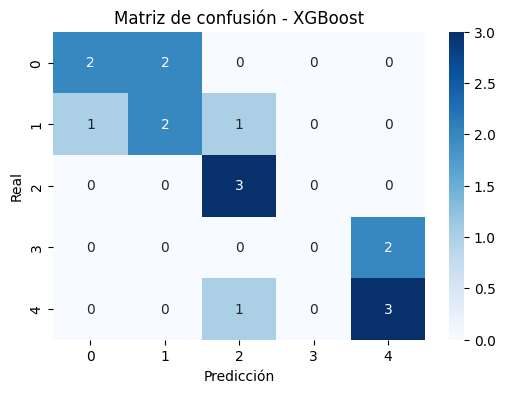

In [12]:
for nombre, info in modelos.items():
    print(f"\n=== Entrenando {nombre} ===")
    grid = GridSearchCV(
        info["modelo"],
        info["param_grid"],
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    mejor_modelo = grid.best_estimator_
    y_pred = mejor_modelo.predict(X_test)

    print(f"\nMejores parámetros para {nombre}: {grid.best_params_}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    resultados[nombre] = {
        "modelo": mejor_modelo,
        "y_pred": y_pred,
        "score": grid.best_score_
    }

    # Matriz de confusión
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

In [13]:
print("\nResumen de desempeño (F1 promedio en validación cruzada):")
for modelo, datos in resultados.items():
    print(f"{modelo}: {datos['score']:.4f}")


Resumen de desempeño (F1 promedio en validación cruzada):
RandomForest: 0.8379
SVM: 0.7946
XGBoost: 0.7209


In [14]:
import joblib

# 1. Elegimos el mejor modelo (puedes fijarlo o hacerlo automático)
mejor_nombre = max(resultados, key=lambda n: resultados[n]["score"])
mejor_modelo_final = resultados[mejor_nombre]["modelo"]
print("Mejor modelo global:", mejor_nombre)

# 2. Guardamos TODO lo necesario en un diccionario
paquete_modelo = {
    "modelo": mejor_modelo_final,
    "label_encoder": label_encoder,
    "feature_columns": X.columns.tolist()
}

# 3. Lo guardamos en un archivo .pkl
joblib.dump(paquete_modelo, "activity_classifier.pkl")

print("Modelo guardado como activity_classifier.pkl")

from google.colab import files
files.download("activity_classifier.pkl")


Mejor modelo global: RandomForest
Modelo guardado como activity_classifier.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Interpretación de resultados de los modelos

### **1. Random Forest**

**Mejores hiperparámetros:**
`{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}`

**Desempeño general:**

* **Accuracy:** 0.76
* **F1 promedio:** 0.73
* Buen equilibrio entre precisión y recall, aunque con pequeñas confusiones entre las clases *caminar_atras* y *caminar_hacia_adelante*.

**Análisis:**

* El modelo logra identificar correctamente la mayoría de las clases, especialmente *girar_derecha* y *sentarse*, donde alcanzó un F1 cercano a 1.0.
* Sin embargo, la clase *caminar_atras* muestra bajo *recall* (0.25), indicando que el modelo confunde estas muestras con *caminar_hacia_adelante*.
* La matriz de confusión evidencia que, aunque el modelo generaliza bien, **las actividades con movimientos similares son las más difíciles de separar**.

**Conclusión parcial:**
Random Forest ofrece **un rendimiento sólido y estable**, con alta capacidad de generalización y buen balance de métricas. Es el modelo más confiable hasta el momento para un sistema base.

### **2. SVM (Support Vector Machine)**

**Mejores hiperparámetros:**
`{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}`

**Desempeño general:**

* **Accuracy:** 0.76
* **F1 promedio:** 0.79 (ligeramente superior al Random Forest)
* Muestra un equilibrio más uniforme entre clases.

**Análisis:**

* Las clases *girar_derecha*, *pararse* y *sentarse* obtienen métricas perfectas (precisión y recall = 1.0), lo que refleja una excelente capacidad de separación.
* Las clases *caminar_atras* y *caminar_hacia_adelante* mantienen confusiones mutuas, lo que indica que el modelo aún tiene dificultad para diferenciar desplazamientos similares.
* En la matriz de confusión se ve que **SVM logró reducir los falsos negativos** respecto a Random Forest.

**Conclusión parcial:**
SVM se comporta **de manera consistente y robusta**, superando ligeramente al Random Forest en métricas promedio. Es un modelo más preciso, aunque puede requerir más tiempo de cómputo.

### **3. XGBoost**

**Mejores hiperparámetros:**
`{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}`

**Desempeño general:**

* **Accuracy:** 0.59
* **F1 promedio:** 0.50
* Desempeño inferior en comparación con los otros dos modelos.

**Análisis:**

* Aunque XGBoost logra clasificar correctamente *girar_derecha* y *sentarse*, tiene grandes dificultades con *pararse* (recall = 0.00), lo que indica **una falta de muestras suficientes o sobreajuste parcial**.
* La matriz de confusión muestra predicciones dispersas y confusiones en las clases de movimiento, especialmente entre *caminar_hacia_adelante* y *caminar_atras*.
* Este comportamiento puede deberse a que el dataset es pequeño y XGBoost requiere más datos para aprender correctamente las fronteras de decisión.

**Conclusión parcial:**
XGBoost presenta **menor rendimiento** para este conjunto de datos. Podría mejorar con más muestras o ajustando la regularización (`lambda`, `alpha`). Actualmente, sufre de **falta de generalización**.

## Objetivo del Plan de Despliegue

El **plan de despliegue** describe cómo llevar tu sistema desde un entorno de desarrollo (local o de laboratorio) hasta un entorno operativo donde pueda ser utilizado por usuarios finales. Debe garantizar que el modelo de IA, la interfaz y el sistema de captura funcionen correctamente en tiempo real.

## 1. Preparación del Entorno

**Objetivo:** asegurar que todo el software y hardware necesario esté correctamente configurado antes del despliegue.

**Componentes principales:**

* **Hardware:**

  * Computador con GPU (preferible NVIDIA) o CPU de alto rendimiento.
  * Cámara web o cámara IP compatible con OpenCV o MediaPipe.
* **Software:**

  * Python 3.10+
  * Librerías: `mediapipe`, `opencv-python`, `scikit-learn`, `numpy`, `pandas`, `matplotlib`, `streamlit` o `tkinter` (para interfaz).
  * Sistema operativo: Ubuntu o Windows 10+.
* **Configuración inicial:**

  * Instalar dependencias vía `requirements.txt`.
  * Clonar el repositorio GitHub.
  * Verificar conexión y permisos de cámara.

## 2. Arquitectura de Despliegue

**Estructura propuesta:**

```
Proyecto_IA/
 ├── Entrega2/
 │   ├── modelos/
 │   │   ├── modelo_clasificador.pkl
 │   ├── data/
 │   │   ├── videos_etiquetados/
 │   ├── src/
 │   │   ├── detector.py          # detección y extracción de landmarks
 │   │   ├── clasificador.py      # predicción de actividad
 │   │   ├── interfaz.py          # visualización en tiempo real
 │   ├── requirements.txt
 │   ├── app.py                   # script principal
```

**Flujo general:**

1. Captura de video en tiempo real.
2. Extracción de *landmarks* con MediaPipe.
3. Normalización y filtrado.
4. Paso de características al modelo entrenado (SVM, RF, etc.).
5. Visualización de la actividad clasificada y los ángulos articulares.

## 3. Estrategia de Despliegue


| Etapa                                   | Descripción                                                                               | Herramientas / Recursos       |
| --------------------------------------- | ----------------------------------------------------------------------------------------- | ----------------------------- |
| **1. Pruebas locales**                  | Verificar funcionamiento en tu entorno local con videos de prueba.                        | Python, MediaPipe, OpenCV     |
| **2. Despliegue en entorno controlado** | Ejecutar en otro computador o entorno virtual (colab, servidor local).                    | Conda o Docker                |
| **3. Interfaz de usuario**              | Implementar una interfaz con Streamlit o Tkinter para mostrar las predicciones y ángulos. | Streamlit                     |
| **4. Validación en tiempo real**        | Probar con nuevas personas, distintas condiciones de iluminación y fondo.                 | Dataset adicional             |
| **5. Despliegue final**                 | Publicar versión ejecutable (ej. `.exe` o app web).                                       | PyInstaller / Streamlit Cloud |


## 4. Pruebas de Desempeño

Antes de liberar la versión final:

* Validar **precisión, recall y F1-score**.
* Evaluar latencia promedio entre captura y predicción (ideal < 200 ms).
* Medir uso de CPU/GPU y memoria.
* Realizar pruebas con diferentes usuarios y entornos.

## 5. Seguridad y Ética

* Anonimizar los datos de video (no almacenar rostros ni información personal).
* Obtener consentimiento informado de los participantes.
* No compartir los datos sin autorización.
* Incluir licencia y referencias en el repositorio.


## **Análisis inicial de los impactos de la solución en el contexto del problema**

El sistema propuesto de **análisis y anotación de video basado en modelos de inteligencia artificial** tiene como propósito reconocer actividades humanas específicas (caminar, girar, sentarse, ponerse de pie) y estimar movimientos articulares en tiempo real. Esta solución, aplicada al contexto académico y potencialmente clínico, conlleva impactos relevantes en tres dimensiones principales: **tecnológica, social y ética**.

### **1. Impacto tecnológico**

La implementación de una herramienta que emplea **MediaPipe** y algoritmos de clasificación para la detección de posturas y movimientos articulares promueve el desarrollo de sistemas inteligentes aplicables a áreas como la **biomecánica, rehabilitación y análisis deportivo**. Su capacidad de operar en tiempo real con bajo costo computacional contribuye a la **democratización del acceso a tecnologías de análisis del movimiento**, que usualmente requieren equipos costosos de captura óptica.
Además, fomenta la adopción de técnicas de *machine learning* y visión por computador dentro del entorno universitario, fortaleciendo las competencias de investigación y desarrollo de los estudiantes.

### **2. Impacto social**

Desde el punto de vista social, la solución puede **mejorar procesos de evaluación física y seguimiento del progreso motor** en diversos escenarios:

* **Educación y entrenamiento físico**, al proporcionar retroalimentación visual inmediata sobre la postura y los movimientos.
* **Rehabilitación clínica**, donde terapeutas podrían utilizar el sistema como apoyo para analizar la evolución de pacientes sin requerir dispositivos invasivos o costosos.
* **Seguridad y ergonomía laboral**, ayudando a identificar posturas que puedan generar riesgo de lesión en entornos de trabajo repetitivo.

Estos beneficios impulsan la inclusión de herramientas de IA accesibles, reduciendo la brecha entre investigación y aplicación práctica.

### **3. Impacto ético y de privacidad**

El uso de videos que capturan personas implica riesgos relacionados con la **privacidad y el manejo responsable de datos personales**. Por ello, se requiere:

* Obtener consentimiento informado antes de grabar o usar videos de individuos.
* Anonimizar los datos, evitando el almacenamiento o difusión de rostros e información sensible.
* Utilizar los datos únicamente con fines académicos y bajo los lineamientos de protección de datos personales.

La implementación responsable de estas medidas es fundamental para garantizar la aceptación y confianza en la tecnología.